## 2.1 Модельная часть

Исходная функция: $-0.1h+2+cos(1.5h)$  
Носитель для $h$: $-1 < h < 1.5$  
Дисперсия шума $\sigma^2$: $0.5$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin

In [2]:
f = lambda h: -0.1 * h + 2 + np.cos(1.5 * h)

sigma2 = 0.5

N_train = 60
N_test = 40

start_train = -1
stop_train = 1.5

h_train, step = np.linspace(start_train, stop_train, N_train, retstep=True)

start_test = start_train - step * (N_test // 2)
stop_test = stop_train + step + step * (N_test // 2)

h_test_left = np.arange(start_test, start_train, step)
h_test_right = np.arange(stop_train+step, stop_test, step)
h_test = np.concatenate((h_test_left, h_test_right))
h = np.concatenate((h_test_left, h_train, h_test_right))

f_train = f(h_train)
f_full = f(h)

X_train_str = f_train + np.random.normal(0, np.sqrt(sigma2), N_train)
X_train = np.column_stack([X_train_str]) #f_train + np.random.normal(0, sigma, N_train)
X_test_left = f(h_test_left) + np.random.normal(0, np.sqrt(sigma2), N_test // 2)
X_test_right = f(h_test_right) + np.random.normal(0, np.sqrt(sigma2), N_test // 2)
X_test = np.concatenate((X_test_left, X_test_right))
X = np.concatenate((X_test_left, X_train_str, X_test_right))

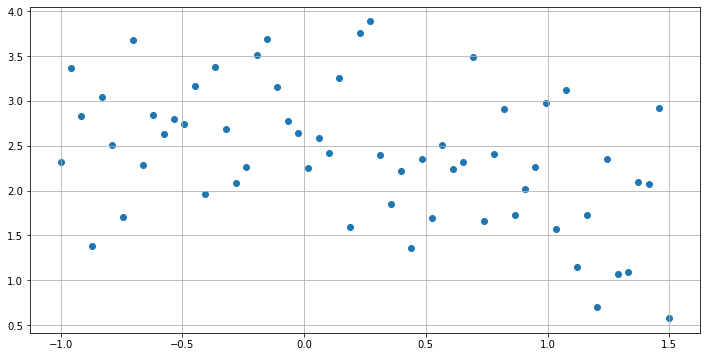

In [3]:
plt.figure(figsize=(12,6))
plt.scatter(h_train, X_train_str)
plt.grid()

### 2.2 **МНК, линейная регрессия**

In [45]:
H = np.column_stack([np.ones(N_train), h_train])

MSE = lambda X, Y: np.linalg.inv(X.T @ X) @ X.T @ Y

linear_regression = lambda theta, x: theta[0] + theta[1] * x

theta_MSE = MSE(H, X_train)
print(theta_MSE)
y_MSE = np.column_stack([linear_regression(theta_MSE, h)])
y_train_MSE = np.column_stack([linear_regression(theta_MSE, h_train)])


[[ 2.51009794]
 [-0.43807187]]


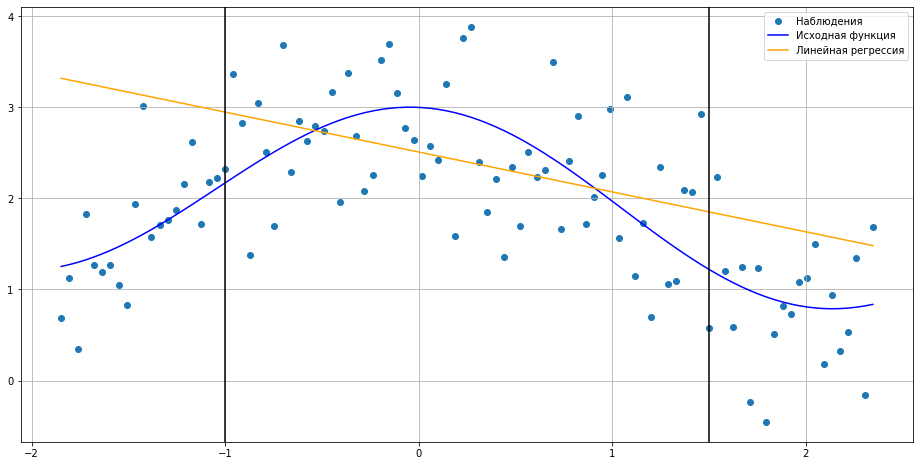

In [5]:
def graph(y):
    plt.figure(figsize=(16,8))
    plt.scatter(h, X, label='Наблюдения')
    plt.plot(h, f_full, color='blue', label='Исходная функция')
    plt.plot(h, y, color='orange', label='Линейная регрессия')
    ax = plt.gca()
    ax.axvline(x=-1, color='k')
    ax.axvline(x=1.5, color='k')
    plt.legend()
    plt.grid()
    
graph(y_MSE)

**Коэффициент детерминации**

In [6]:
def e(X, y):
    e = X - y
    return np.sum(e ** 2)

def R(X, y):   
    ss_res = e(X, y)
    ss_tot = np.sum((X - X.mean()) ** 2)
    R = 1 - ss_res / ss_tot
    
    return R

print(R(X_train, y_train_MSE))

0.1786056537033539


**Оценка ковариационной матрицы**

In [7]:
def K(X, y):
    ss_res = e(X, y)
    sigma2_hat = ss_res / (N_train - 1)
    K_hat = sigma2_hat * np.linalg.inv(H.T @ H)
    return K_hat

print(K(X_train, y_train_MSE))

[[ 0.00899004 -0.00373969]
 [-0.00373969  0.01495875]]


**Информационные критерии**

In [8]:
def IC(X, y, theta=theta_MSE):
    ss_res = e(X, y)
    sigma2_hat = ss_res / (N_train - 1)

    AIC = 2 * len(theta) / N_train + np.log(sigma2_hat)
    BIC = len(theta) * np.log(N_train) + N_train * np.log(sigma2_hat)
    
    return AIC, BIC

print(IC(X_train, y_train_MSE))

(-0.6604365966783875, -35.43750667625905)


**Критерий Фишера**

In [9]:
def Fisher(Z, theta, val, H, k=3.16):
    q = p = len(theta)
    N = len(Z)
    c = [[val] for _ in range(q)]
    A = np.eye(q)
    F =  ((A @ theta - c).T @ np.linalg.inv(A @ np.linalg.inv(H.T @ H) @ A.T) @ (A @ theta - c)) / (q / (N - p) * (Z - H @ theta).T @ (Z - H @ theta))
    print(F)
    if F < k:
        return True
    else:
        return False

In [10]:
Fisher(X_train, theta_MSE, 0, H)

[[357.95250624]]


False

**Доверительные интервалы**

In [11]:
def interval(u, y=y_MSE):
    def d(t):
        h = np.column_stack([[1, t]])
        x = h.T @ np.linalg.inv(H.T @ H) @ h
        return sigma2 * x

    d_full = d(h)[0][0]
    lower = np.squeeze(y.reshape(1, 100)) - u * d_full
    upper = np.squeeze(y.reshape(1, 100)) + u * d_full

    plt.figure(figsize=(20,10))
    plt.scatter(h, X, label='Наблюдения')
    plt.plot(h, f_full, color='blue', label='Исходная функция')
    plt.plot(h, y, color='orange', label='Линейная регрессия')
    plt.plot(h, lower, color='black', label='Доверительный интервал')
    plt.plot(h, upper, color='black')
    plt.legend()
    plt.grid()

/home/alexandra/anaconda3/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = array(v, copy=False, subok=True)


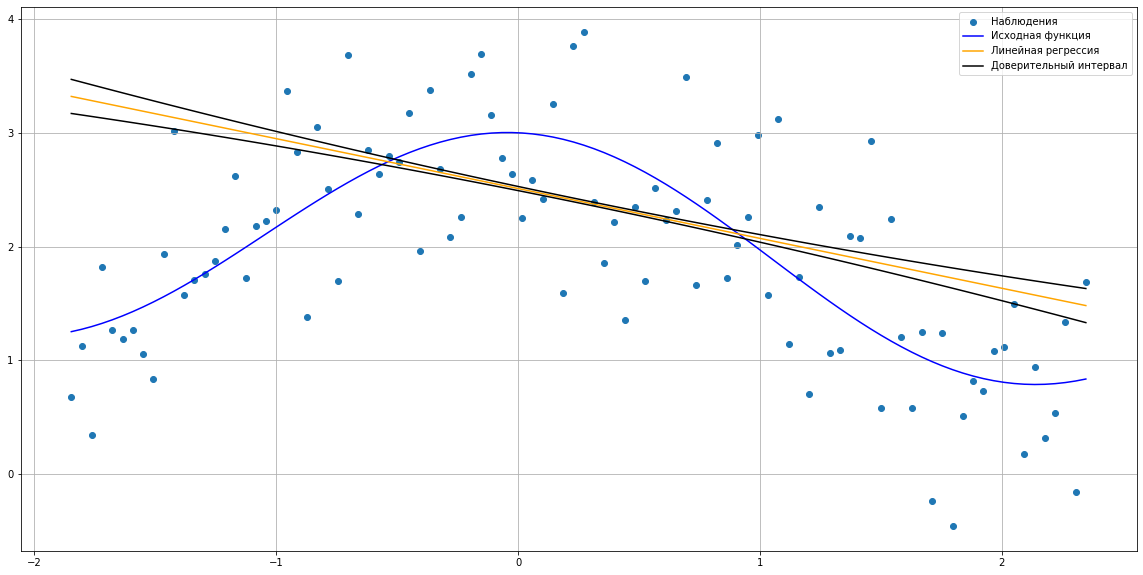

In [12]:
interval(1.96)

/home/alexandra/anaconda3/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = array(v, copy=False, subok=True)


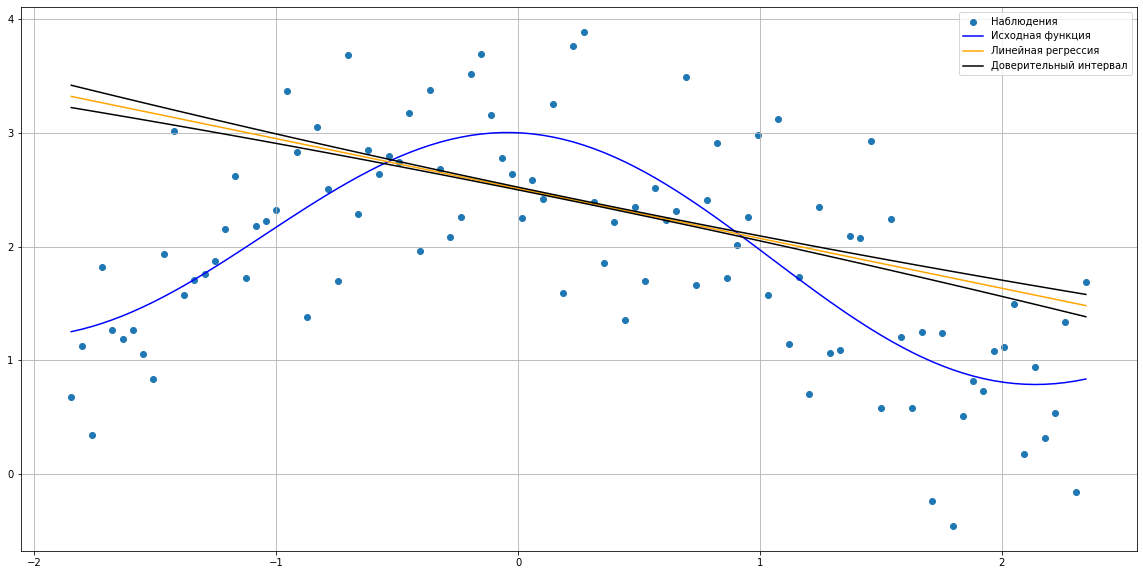

In [13]:
interval(1.282)

**МНМ**

In [14]:
def IRLS(X, Y, maxiter, d=0.0001, t=0.001):
    N = len(Y)
    delta = np.array(np.repeat(d, N)).reshape(1, N)
    w = np.ones(N)
    W = np.diag(w)
    THETA = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ Y)
    for i in range(maxiter):
        THETA_ = THETA
        w_ = abs(Y - np.dot(X, THETA)).T
        w = 1 / np.maximum(delta, w_)
        w = np.squeeze(w)
        W = np.diag(w)
        THETA = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ Y)
        #print(THETA)
        if sum(abs(THETA - THETA_)) < t:
            return THETA
    return THETA

theta_MAE = IRLS(H, X_train_str, 20)
print(theta_MAE)

[ 2.54439713 -0.40809387]


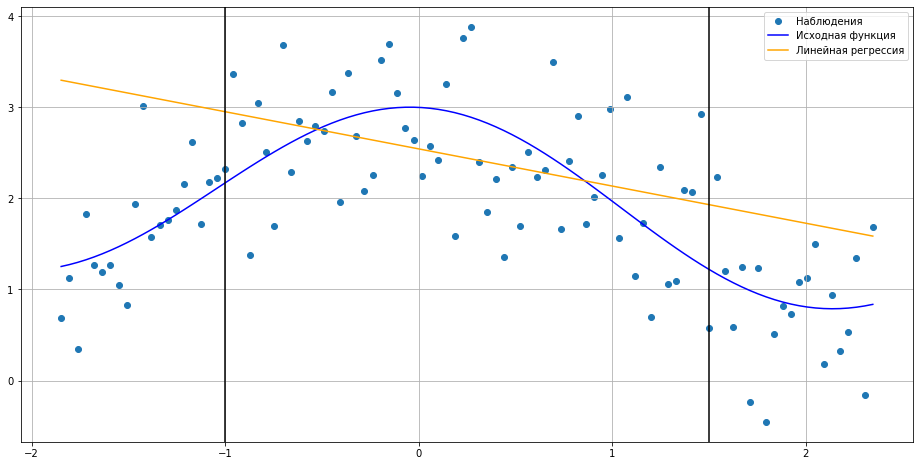

In [15]:
y_MAE = np.column_stack([linear_regression(theta_MAE, h)])
y_train_MAE = np.column_stack([linear_regression(theta_MAE, h_train)])

graph(y_MAE)

**Оценка качества построенных регрессий**

In [16]:
def test_MSE(y, y_hat):
    return np.sum((y - y_hat) ** 2)

def test_MAE(y, y_hat):
    return np.sum(abs(y - y_hat))

y_test_MSE = linear_regression(theta_MSE, h_test)
y_test_MAE = linear_regression(theta_MAE, h_test)


yMSE_MSE = test_MSE(X_test, y_test_MSE)
yMAE_MSE = test_MSE(X_test, y_test_MAE)
print("Сумма квадратов остатков на тестовой выборке, МНК:", yMSE_MSE, "\nСумма квадратов остатков на тестовой выборке, МНМ:", yMAE_MSE)

yMSE_MAE = test_MAE(X_test, y_test_MSE)
yMAE_MAE = test_MAE(X_test, y_test_MAE)
print("Сумма модулей остатков на тестовой выборке, МНК:", yMSE_MAE, "\nСумма модулей остатков на тестовой выборке, МНМ:", yMAE_MAE)

print("\nКоэффициент детерминации на тестовой выборке, МНК:", R(X_test, y_test_MSE))
print("Коэффициент детерминации на тестовой выборке, МНК:", R(X_test, y_test_MAE))

Сумма квадратов остатков на тестовой выборке, МНК: 79.59469960756192 
Сумма квадратов остатков на тестовой выборке, МНМ: 82.1444456997717
Сумма модулей остатков на тестовой выборке, МНК: 48.426071265651075 
Сумма модулей остатков на тестовой выборке, МНМ: 49.727403356028475

Коэффициент детерминации на тестовой выборке, МНК: -2.3987305971174977
Коэффициент детерминации на тестовой выборке, МНК: -2.507605938078654


**Гистограмма остатков**

<AxesSubplot:ylabel='Probability'>

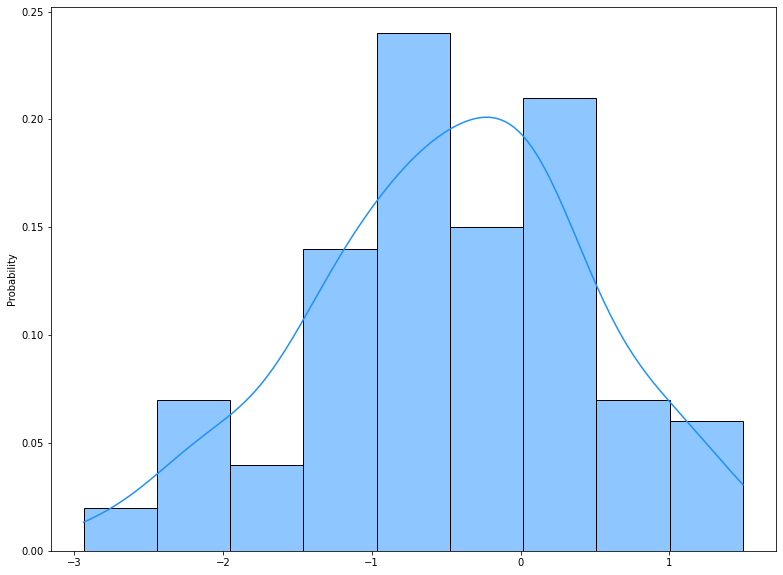

In [17]:
import seaborn as sns

e = X - y_MSE.ravel()
e = np.squeeze(e)

plt.figure(figsize=(13,10))
sns.histplot(e, color="dodgerblue", kde=True, stat='probability')

**Проверка на гауссовское распределение**

In [18]:
from scipy.stats import shapiro, bartlett

shapiro(e)

ShapiroResult(statistic=0.9885260462760925, pvalue=0.5477652549743652)

На уровне значимости $\alpha=0.05$ гипотеза о нормальном распределении остатков принимается

ShapiroResult(statistic=0.9894854426383972, pvalue=0.6231318712234497)

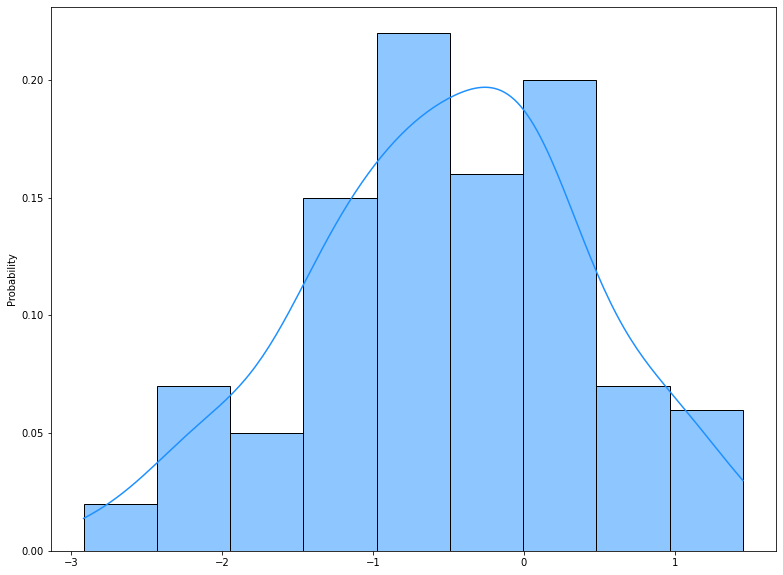

In [25]:
e_test = X - y_MAE.ravel()
plt.figure(figsize=(13,10))
sns.histplot(e_test, color="dodgerblue", kde=True, stat='probability')
shapiro(e_test)

**Проверка наличия автокорреляции**

In [34]:
from statsmodels.stats.stattools import durbin_watson

D = durbin_watson(e)
r_hat = 1 - D / 2
print(D, r_hat)

0.8736325891129147 0.5631837054435427


**Проверка гетероскедастичности**

In [69]:
bartlett(e, e_test)

BartlettResult(statistic=12.027195004890057, pvalue=0.0005242991842487981)

### 2.3 **Полиномиальная регрессия**

In [56]:
from scipy.optimize import least_squares

def polinom(theta, x):
    f = 0
    for i in range(len(theta)):
        f += theta[i] *  x ** i
    return f

theta = lambda n: [1] * n

rho = lambda theta, y, x: y - polinom(theta, x)

def LS(n, y, x):
    theta_ls = least_squares(rho, theta(n), args=(y, x), method='lm') 
    mse = test_MSE(polinom(theta_ls.x, h_test), X_test)
    plt.figure(figsize=(16,8))
    plt.scatter(h, X, label='Наблюдения')
    plt.plot(h, f_full, color='blue', label='Исходная функция')
    plt.plot(h, polinom(theta_ls.x, h), color='orange', label='Полиномиальная регрессия')
    ax = plt.gca()
    ax.axvline(x=-1, color='k')
    ax.axvline(x=1.5, color='k')
    plt.legend()
    plt.grid()
    return theta_ls.x, mse
    #print('Оценка параметров:', theta_ls.x, '\nСумма квадратов остатков на тестовой выборке:', mse)


Оценка параметров: [ 2.51009794 -0.43807187] 
Сумма квадратов остатков на тестовой выборке: 79.59469961058517


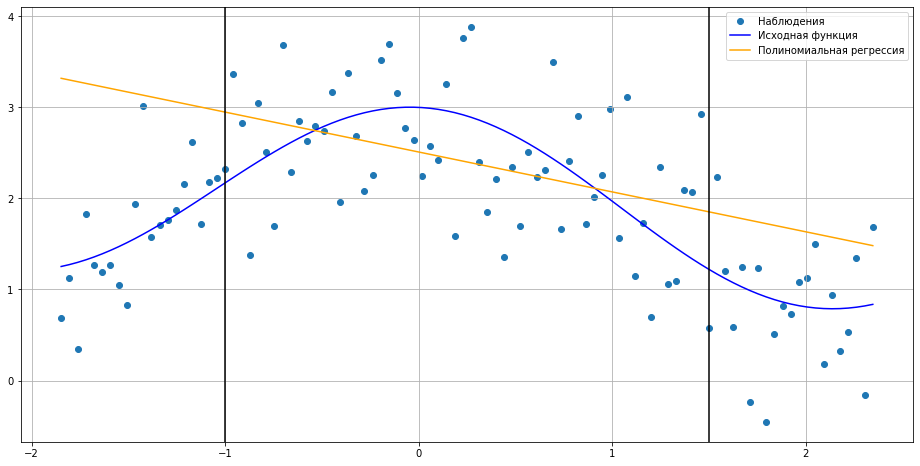

In [58]:
th, mse = LS(2, X_train_str, h_train)
print('Оценка параметров:', th, '\nСумма квадратов остатков на тестовой выборке:', mse)

Оценка параметров: [ 2.68898866 -0.25015699 -0.37582976] 
Сумма квадратов остатков на тестовой выборке: 24.455512648101077


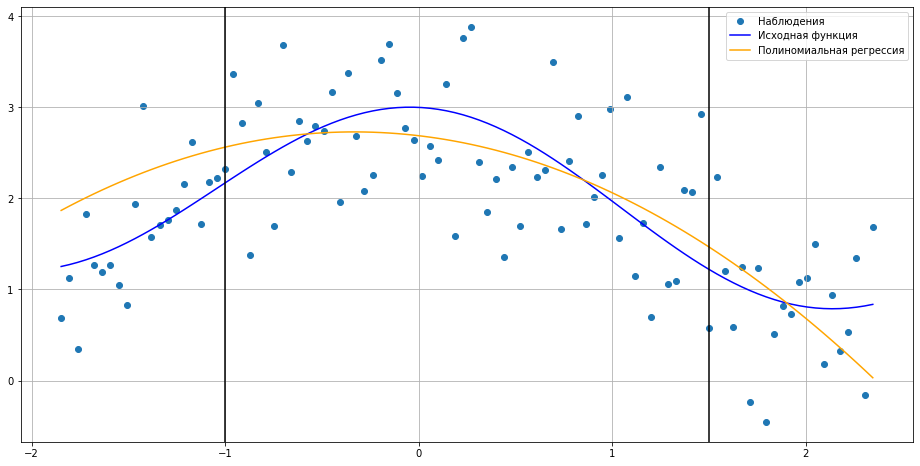

In [59]:
th, mse = LS(3, X_train_str, h_train)
print('Оценка параметров:', th, '\nСумма квадратов остатков на тестовой выборке:', mse)

Оценка параметров: [ 2.7178515  -0.34968699 -0.47135772  0.12737061] 
Сумма квадратов остатков на тестовой выборке: 16.45597441139186


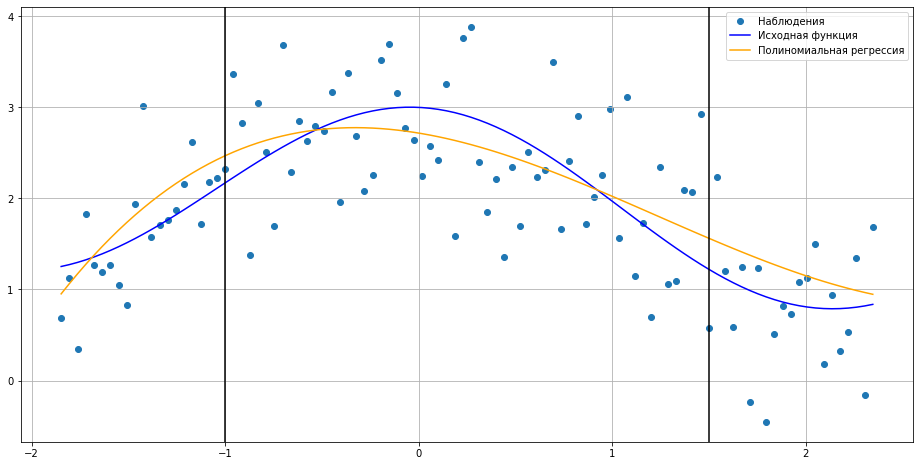

In [60]:
th, mse = LS(4, X_train_str, h_train)
print('Оценка параметров:', th, '\nСумма квадратов остатков на тестовой выборке:', mse)

Оценка параметров: [ 2.72632457 -0.31177905 -0.53211161  0.06712288  0.06024771] 
Сумма квадратов остатков на тестовой выборке: 29.13169908981409


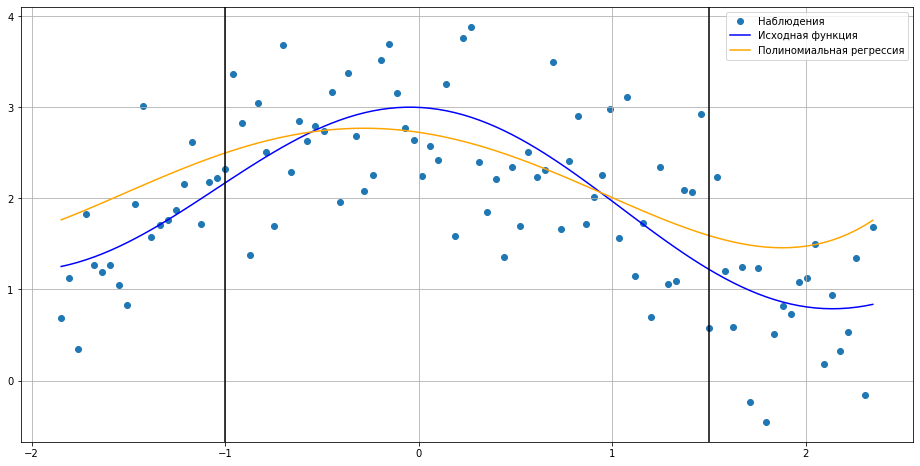

In [61]:
th, mse = LS(5, X_train_str, h_train)
print('Оценка параметров:', th, '\nСумма квадратов остатков на тестовой выборке:', mse)

Сумма квадратов остатков на тестовой выборке возросла, поэтому остановимся на третьей степени полинома

**Анализ остатков**

ShapiroResult(statistic=0.9843894243240356, pvalue=0.2867341935634613)


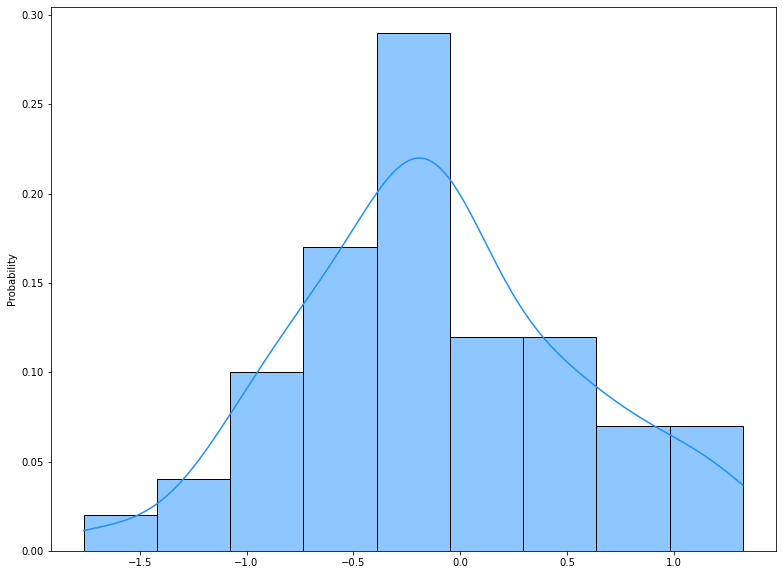

In [67]:
 th = least_squares(rho, theta(4), args=(X_train_str, h_train), method='lm').x

e = X - polinom(th, h)

plt.figure(figsize=(13,10))
sns.histplot(e, color="dodgerblue", kde=True, stat='probability')
print(shapiro(e))

In [68]:
D = durbin_watson(e)
r_hat = 1 - D / 2
print(D, r_hat)

2.1942313808280867 -0.09711569041404333


Можно считать, что автокорреляция отсутствует